In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error, r2_score

pd.pandas.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'numpy'

In [2]:
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [4]:
from feature_engine.imputation import (
MeanMedianImputer,
CategoricalImputer,
)

from feature_engine.encoding import (
OneHotEncoder,
)

## dataset

In [5]:
train = pd.read_csv("../raw/train.csv")
test = pd.read_csv("../raw/test.csv")

In [6]:
train.head()

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,362,363,40.0,female,27.5,98,Yes,1,No,southwest,5003.85
1,483,484,48.0,male,42.4,92,Yes,5,No,southwest,6666.24
2,866,867,59.0,female,33.5,97,No,2,No,northwest,12269.69
3,625,626,26.0,male,27.4,92,No,3,No,northeast,8606.22
4,194,195,57.0,female,26.6,83,No,0,No,northeast,3046.06


In [7]:
train.dtypes

index              int64
PatientID          int64
age              float64
gender            object
bmi              float64
bloodpressure      int64
diabetic          object
children           int64
smoker            object
region            object
claim            float64
dtype: object

In [7]:
test.head()

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,574,575,53.0,female,27.7,88,Yes,0,No,northwest,8026.67
1,661,662,43.0,female,28.9,84,Yes,1,No,northwest,9249.50
2,458,459,34.0,female,40.6,98,No,1,No,northwest,6373.56
3,1023,1024,51.0,female,41.3,98,No,0,No,northeast,17878.90
4,958,959,28.0,female,25.1,103,No,0,No,northwest,14254.61


In [8]:
train.drop(['index', 'PatientID'], axis=1, inplace=True)
test.drop(['index', 'PatientID'], axis=1, inplace=True)

In [9]:
y_train = train['claim']
X_train = train.drop(['claim'], axis=1)

In [10]:
y_test = test['claim']
X_test = test.drop(['claim'], axis=1)

In [11]:
X_train.shape, X_test.shape

((1072, 8), (268, 8))

In [12]:
y_train.shape, y_test.shape

((1072,), (268,))

In [13]:
X_train.head()

,age,gender,bmi,bloodpressure,diabetic,children,smoker,region
0,40.0,female,27.5,98,Yes,1,No,southwest
1,48.0,male,42.4,92,Yes,5,No,southwest
2,59.0,female,33.5,97,No,2,No,northwest
3,26.0,male,27.4,92,No,3,No,northeast
4,57.0,female,26.6,83,No,0,No,northeast


## Target 

In [14]:
y_train = np.log(y_train)
y_test = np.log(y_test)

## Config

In [15]:
cat_na = ['region']
num_na = ['age']

cat_vars = ['gender', 'diabetic', 'smoker', 'region']
num_vars = ['age', 'bmi', 'bloodpressure', 'children']

In [16]:
predict_pipe = Pipeline([
    ('frequent_imputation', CategoricalImputer(
    imputation_method='frequent', variables=cat_na)),
    
    ('mean_imputation', MeanMedianImputer(
    imputation_method='mean', variables=num_na)),
    
    ("categorical_encoder", OneHotEncoder(
        drop_last=True, variables=cat_vars)),
    
    ("scaler", MinMaxScaler()),
    ("RandomForest", RandomForestRegressor(random_state=0, n_estimators=200, max_depth=7))
    ]
)

In [18]:
predict_pipe.fit(X_train, y_train)

Pipeline(steps=[('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['region'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['age'])),
                ('categorical_encoder',
                 OneHotEncoder(drop_last=True,
                               variables=['gender', 'diabetic', 'smoker',
                                          'region'])),
                ('scaler', MinMaxScaler()),
                ('RandomForest',
                 RandomForestRegressor(max_depth=7, n_estimators=200,
                                       random_state=0))])

In [19]:
pred = predict_pipe.predict(X_test)

In [21]:
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

test mse: 35428320
test rmse: 5952
test r2: 0.7421809025385853



Text(0.5, 1.0, 'Evaluation of Random forest for test set')

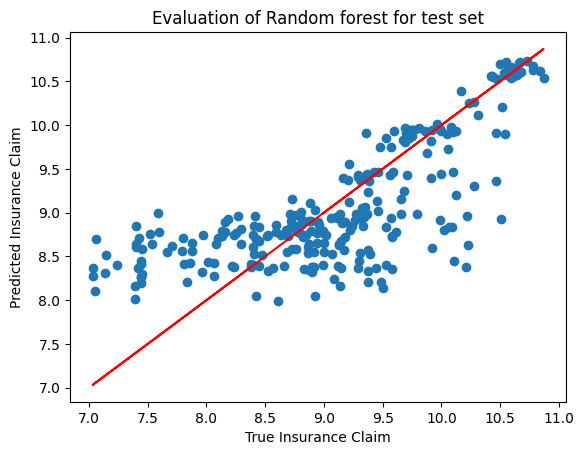

In [23]:
plt.scatter(y_test, predict_pipe.predict(X_test))

plt.plot(y_test, y_test, color='red')

plt.xlabel('True Insurance Claim')
plt.ylabel('Predicted Insurance Claim')
plt.title('Evaluation of Random forest for test set')